In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv

import geopandas as gpd
import fiona


from shapely.geometry import Point, Polygon
import seaborn as sns

from sklearn.cluster import KMeans
import math

from pandas.api.types import is_numeric_dtype

from sklearn.model_selection import train_test_split
!pip install catboost

from catboost import CatBoostRegressor, Pool
import catboost as cb
from sklearn.metrics import mean_squared_error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.6 MB/s eta 0:00:00


# Load Data and Preprocess

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
barcelona_df = pd.read_csv("/content/drive/MyDrive/AIT Classes/Data Science/Project/denver_listings.csv")
barcelona_df = barcelona_df.dropna(subset=['price'])

print(len(barcelona_df.columns))

75


In [4]:
# convert price to float
price_list = []
for price in barcelona_df['price']:
    cleaned = price.replace(',', '')
    price_list.append(float(cleaned[1:]))

barcelona_df['price_float'] = price_list

In [5]:
print(barcelona_df.shape)
barcelona_df = barcelona_df[barcelona_df['price_float'] <= 500.0]
print(barcelona_df.shape)

(4889, 76)
(4740, 76)


# Feature Extraction: Distance to City Center

In [6]:
# load Barcelona Map
street_map = gpd.read_file('/content/drive/MyDrive/AIT Classes/Data Science/Project/denver.shp')

In [7]:
# Plot the listings in the map
geometry = [Point(xy) for xy in zip(barcelona_df['longitude'], barcelona_df['latitude'])]
geo_df = gpd.GeoDataFrame(barcelona_df, geometry=geometry) #specify the geometry list we created

Text(0.5, 1.0, 'Loacations of the listing across the city')

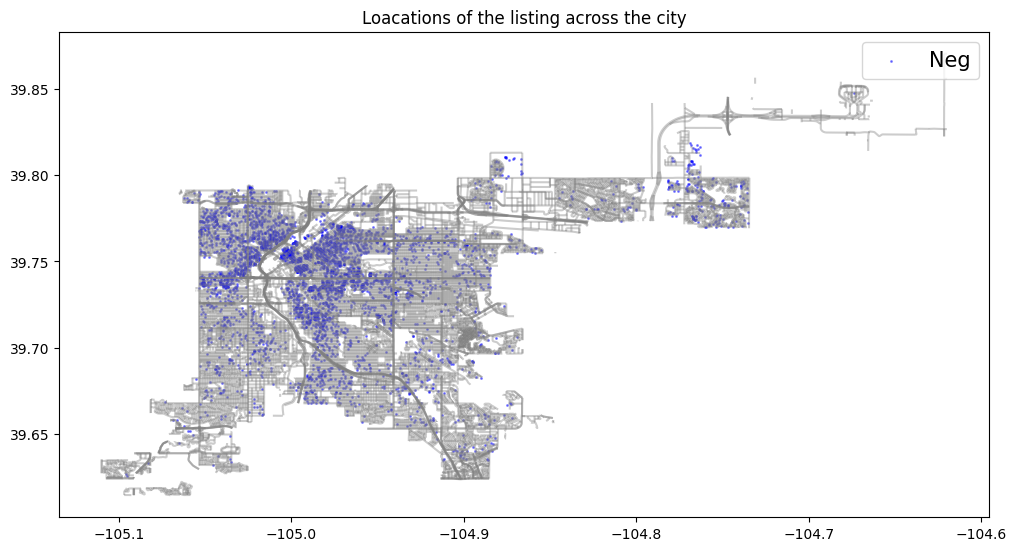

In [8]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')

geo_df.plot(ax=ax, markersize=5, color='blue', marker='.', label='Neg', alpha=0.4)
plt.legend(prop={'size':15})
plt.title('Loacations of the listing across the city')

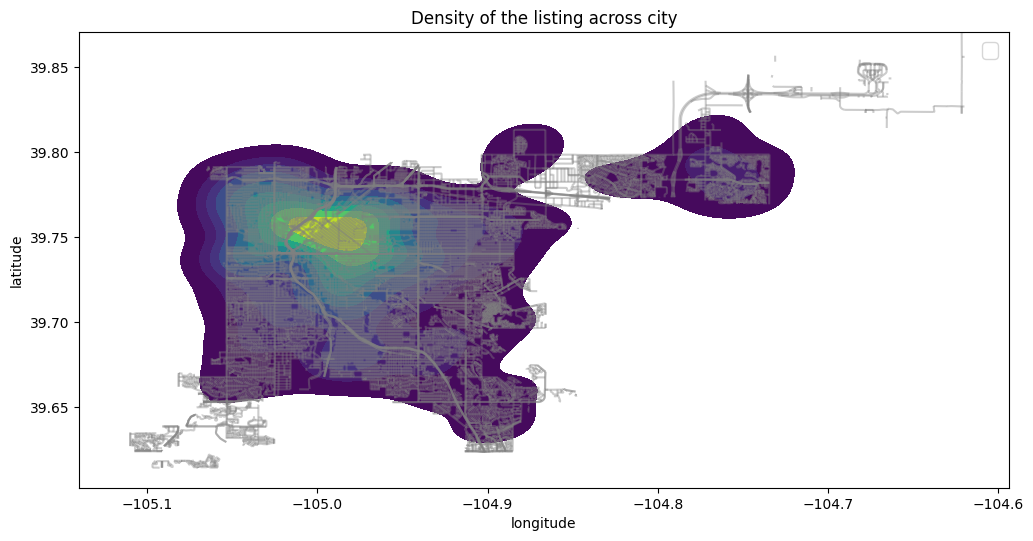

In [9]:
# Density of the listing across city
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')

kde = sns.kdeplot(data=geo_df, x='longitude', y='latitude', fill=True, cmap='viridis', ax=ax, thresh=0.025)#.0025
# cbar = plt.colorbar(kde.collections[0], ax=ax, label='Density')
plt.title('Density of the listing across city')
plt.legend(prop={'size':15})

In [10]:
# Kmeans clustering
coordinates = barcelona_df[['latitude', 'longitude']]

num_clusters = 8
kmean_cluster = KMeans(n_clusters=num_clusters, random_state=42)
barcelona_df['cluster'] = kmean_cluster.fit_predict(coordinates)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


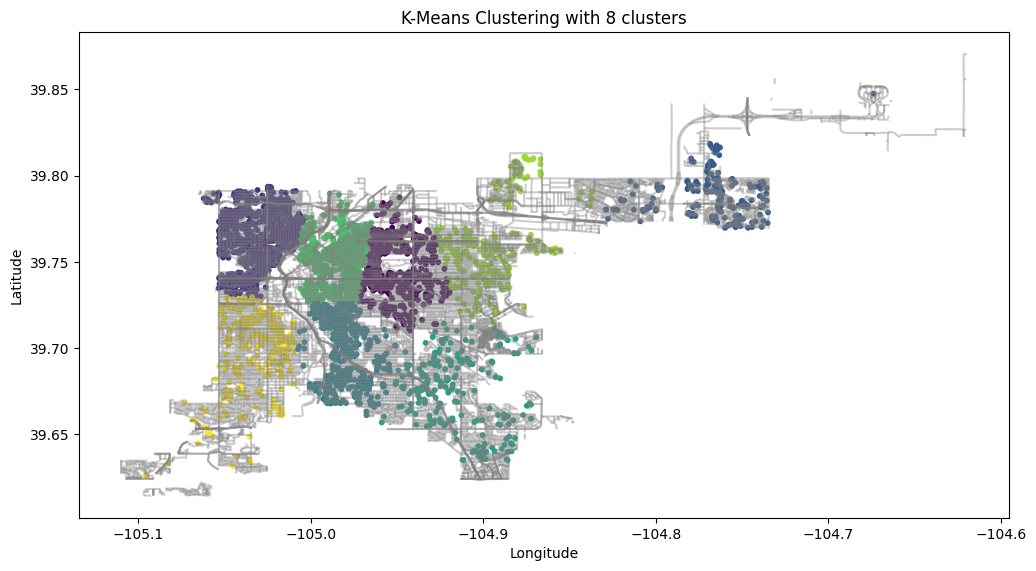

In [11]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')
plt.scatter(barcelona_df['longitude'], barcelona_df['latitude'], c=barcelona_df['cluster'], cmap='viridis', s=10)
plt.title(f'K-Means Clustering with {num_clusters} clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [12]:
densest_cluster = np.argmax(np.bincount(barcelona_df['cluster']))
densest_cluster_lat_longs = coordinates[barcelona_df['cluster'] == densest_cluster]
centroid = [np.mean(densest_cluster_lat_longs['latitude']), np.mean(densest_cluster_lat_longs['longitude'])] # [latitude, longitude]
print(f"Coordinates of the densest spot (centroid of the densest cluster): {centroid}")

Coordinates of the densest spot (centroid of the densest cluster): [39.75135139770403, -104.98618843988109]


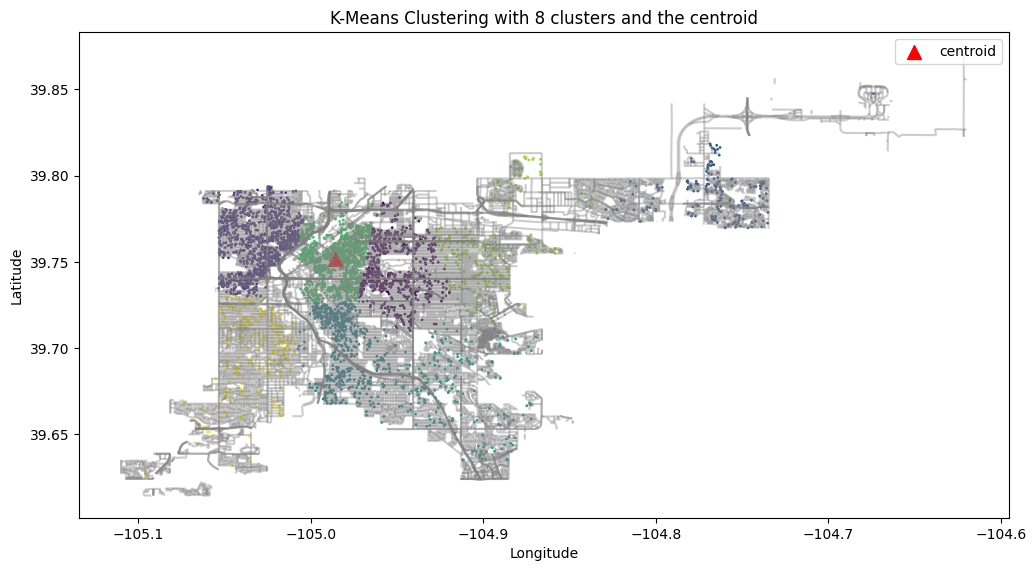

In [13]:
fig, ax = plt.subplots(figsize=(12,12))
street_map.plot(ax=ax, alpha=0.4, color='grey')
plt.scatter(barcelona_df['longitude'], barcelona_df['latitude'], c=barcelona_df['cluster'], cmap='viridis', s=1)
plt.scatter(centroid[1], centroid[0], c = 'red', marker='^', s = 100, label = 'centroid')
plt.title(f'K-Means Clustering with {num_clusters} clusters and the centroid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [14]:
# adding distance to city center to the dataframe
dist_to_cen = []
for i in range(len(barcelona_df)):
    dist_to_cen.append(math.dist(centroid, [barcelona_df.iloc[i][30], barcelona_df.iloc[i][31]]))

print(min(dist_to_cen))
print(dist_to_cen)
barcelona_df['to_city_center'] = dist_to_cen

0.0015682626583293324
[0.05722674295518671, 0.05376666626986954, 0.0075198965585717, 0.06632800819212632, 0.039564943340047204, 0.03639343845476654, 0.05474146118838603, 0.046004157283183335, 0.061297968321178356, 0.062109312585516156, 0.026273406398533847, 0.015408007939971186, 0.048842070006744606, 0.02349920053315706, 0.022799571594003448, 0.02982454403411026, 0.02270864349880529, 0.00616516546916872, 0.009271790321308338, 0.08536397917120828, 0.007504336922736239, 0.01509688912991466, 0.018606476827224765, 0.05142093682314134, 0.21914673406355056, 0.014182406153791764, 0.03319526015221584, 0.0037947663582010224, 0.027234726459839632, 0.007287296173250082, 0.026063490721453, 0.05663919429434562, 0.021242379124031856, 0.011265778340611286, 0.0885301324756981, 0.041142923328499746, 0.01737667136468533, 0.09963855651445316, 0.1283150949491976, 0.02985236877257163, 0.043424475026662204, 0.025580995997666816, 0.02583396182460921, 0.05007285795888078, 0.06646913473937349, 0.03355408455712

# dropping useless features

In [15]:
# insights about barcelona_df: bathrooms has only NaNs, create categoricals into strings, feature extraction on amenities,
not_useful = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location',
            'host_thumbnail_url', 'host_picture_url', 'host_verifications', 'neighbourhood', 'bathrooms', 'price', 'calendar_updated',
             'calendar_last_scraped', 'first_review', 'last_review', 'license', 'cluster' ]

# dropped for now / for this project
might_be_useful = ['name', 'description', 'neighborhood_overview', 'host_about' ]

# host_since: date handling, host_response_time = categorical integration possible, host_neighbourhood: have to see if whether useful or not
# amenities: feature extraction possible,
flagged_col = ['host_since', 'host_response_time', 'host_neighbourhood', 'latitude', 'longitude', 'amenities', ]

# host_response_rate, host_acceptance_rate: format %, host_has_profile_pic: format datatype('0'), property_type: drop low frequency unique values
to_format = ['host_response_rate', 'host_acceptance_rate', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed','neighbourhood_group_cleansed',
            'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'has_availability', 'instant_bookable',  ]

TO_DROP = not_useful + might_be_useful + flagged_col + to_format

integrated_directly = ['host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
                      'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
                      'maximum_nights_avg_ntm', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
                      'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location', 'review_scores_value', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                      'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'price_float', 'to_city_center']

print(len(not_useful) + len(might_be_useful) + len(flagged_col) + len(to_format) + len(integrated_directly))
print(len(barcelona_df.columns))
print(barcelona_df.columns[len(not_useful) + len(might_be_useful) + len(flagged_col) + len(to_format) + len(integrated_directly)-1])

78
78
to_city_center


In [16]:
pre_filtered_barcelona_df = barcelona_df.drop(columns=(not_useful + might_be_useful + flagged_col), axis=1)

print(pre_filtered_barcelona_df.shape)
pre_filtered_barcelona_df.head()

(4740, 46)


,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,...,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_float,to_city_center
0,100%,75%,f,8,23,t,t,North Park Hill,NaN,Private room in home,...,4.00,3.00,f,6,2,4,0,0.11,35.0,0.057227
1,NaN,0%,f,1,2,t,t,Hale,NaN,Entire rental unit,...,NaN,NaN,f,1,1,0,0,NaN,149.0,0.053767
3,100%,100%,t,58,70,t,t,Five Points,NaN,Entire townhouse,...,4.93,4.59,f,20,20,0,0,2.52,190.0,0.007520
4,100%,100%,t,2,2,t,t,West Colfax,NaN,Entire townhouse,...,NaN,NaN,t,1,1,0,0,NaN,87.0,0.066328
5,NaN,91%,f,1,1,t,f,Sunnyside,NaN,Entire home,...,4.92,4.92,f,1,1,0,0,0.99,300.0,0.039565


# fix/convert some useful attributes

In [17]:
# response rate and acceptance rate
resp_rate = []
accept_rate = []

for r_rate in pre_filtered_barcelona_df['host_response_rate']:
  r = str(r_rate)
  if (r == 'nan'):
    resp_rate.append(int(0))
  else:
    resp_rate.append(int(r[:-1]))

for a_rate in pre_filtered_barcelona_df['host_acceptance_rate']:
  a = str(a_rate)
  if (a == 'nan'):
    accept_rate.append(int(0))
  else:
    accept_rate.append(int(a[:-1]))

pre_filtered_barcelona_df['host_response_rate'] = resp_rate
pre_filtered_barcelona_df['host_acceptance_rate'] = accept_rate

print(pre_filtered_barcelona_df.shape)

(4740, 46)


In [18]:
def to_binary_encoding(df, name):
  tracker = []
  for val in df[name]:
    if (str(val) == 't'):
      tracker.append(int(1))
    else:
      tracker.append(int(0))
  return tracker

formatted = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'has_availability', 'instant_bookable']
for fr in formatted:
  pre_filtered_barcelona_df[f'{fr}_formatted'] = to_binary_encoding(pre_filtered_barcelona_df, fr)
pre_filtered_barcelona_df.drop(columns=formatted, inplace=True)

In [19]:
pre_filtered_barcelona_df.head()

,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms_text,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,price_float,to_city_center,host_is_superhost_formatted,host_has_profile_pic_formatted,host_identity_verified_formatted,has_availability_formatted,instant_bookable_formatted
0,100,75,8,23,North Park Hill,NaN,Private room in home,Private room,1,1 shared bath,...,4,0,0.11,35.0,0.057227,0,1,1,1,0
1,0,0,1,2,Hale,NaN,Entire rental unit,Entire home/apt,6,2 baths,...,0,0,NaN,149.0,0.053767,0,1,1,1,0
3,100,100,58,70,Five Points,NaN,Entire townhouse,Entire home/apt,8,2.5 baths,...,0,0,2.52,190.0,0.007520,1,1,1,1,0
4,100,100,2,2,West Colfax,NaN,Entire townhouse,Entire home/apt,5,2.5 baths,...,0,0,NaN,87.0,0.066328,1,1,1,1,1
5,0,91,1,1,Sunnyside,NaN,Entire home,Entire home/apt,3,1 bath,...,0,0,0.99,300.0,0.039565,0,1,0,1,0


In [20]:
def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

categorical_indicies = get_categorical_indicies(pre_filtered_barcelona_df)
print(categorical_indicies)

[4, 6, 7, 9]


In [21]:
cat_names = []
for cat_i in categorical_indicies:
  print(pre_filtered_barcelona_df.columns[cat_i])
  cat_names.append(pre_filtered_barcelona_df.columns[cat_i])

print(' ====> dimension before dropping: ', pre_filtered_barcelona_df.shape)
pre_filtered_barcelona_df.drop(columns=cat_names, inplace=True)
print(' ====> dimension after droppnig: ', pre_filtered_barcelona_df.shape)

neighbourhood_cleansed
property_type
room_type
bathrooms_text
 ====> dimension before dropping:  (4740, 46)
 ====> dimension after droppnig:  (4740, 42)


In [22]:
col_used = pre_filtered_barcelona_df.columns
with open('/content/sample_data/columns_used.txt', 'w') as file:
  for i, col in enumerate(col_used):
    file.write(f'{i+1}: {col}\n')

# Train Model

In [23]:
y = pre_filtered_barcelona_df['price_float']
pre_filtered_barcelona_df = pre_filtered_barcelona_df.drop(columns='price_float',axis=1)
X = pre_filtered_barcelona_df

print(pre_filtered_barcelona_df.shape)

(4740, 41)


In [24]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create CatBoost Pools for training, validation, and test sets
train_pool = cb.Pool(X_train, label=y_train)
val_pool = cb.Pool(X_val, label=y_val)
test_pool = cb.Pool(X_test, label=y_test)

# Create a CatBoostRegressor
catboost_regressor = CatBoostRegressor(iterations=100, depth=7, learning_rate=0.1, loss_function='RMSE', random_seed=42)

# Train the model using the training Pool and validate on the validation set
catboost_regressor.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=10)

# Make predictions on the test set
y_pred = catboost_regressor.predict(test_pool)

0:	learn: 84.6600897	test: 82.4178189	best: 82.4178189 (0)	total: 54.8ms	remaining: 5.43s
10:	learn: 66.5727616	test: 67.0567597	best: 67.0567597 (10)	total: 119ms	remaining: 967ms
20:	learn: 60.2025847	test: 62.5205856	best: 62.5205856 (20)	total: 184ms	remaining: 691ms
30:	learn: 56.9194780	test: 60.5831950	best: 60.5831950 (30)	total: 250ms	remaining: 556ms
40:	learn: 54.6682470	test: 59.4742651	best: 59.4742651 (40)	total: 318ms	remaining: 458ms
50:	learn: 52.8593776	test: 58.9275090	best: 58.9275090 (50)	total: 377ms	remaining: 362ms
60:	learn: 51.6402912	test: 58.0165798	best: 58.0165798 (60)	total: 457ms	remaining: 292ms
70:	learn: 50.3891539	test: 57.6973966	best: 57.6973966 (70)	total: 530ms	remaining: 216ms
80:	learn: 49.1624717	test: 57.3238838	best: 57.3238838 (80)	total: 593ms	remaining: 139ms
90:	learn: 47.9519772	test: 57.0871081	best: 57.0871081 (90)	total: 653ms	remaining: 64.6ms
99:	learn: 46.9733199	test: 56.8110626	best: 56.7889835 (98)	total: 710ms	remaining: 0us



In [38]:
print(len(pre_filtered_barcelona_df.columns))

46


# Save dataframe with overpricing and prediction data


In [25]:
y_pred_all = catboost_regressor.predict(pre_filtered_barcelona_df)

# Add the predictions as a new column named 'prediction' to pre_filtered_barcelona_df
pre_filtered_barcelona_df['prediction'] = y_pred_all

# logging overpriced/underpriced (1 for overpriced and 0 for underpriced)
pre_filtered_barcelona_df['price_float'] = y

pre_filtered_barcelona_df['overpriced'] = np.where(pre_filtered_barcelona_df['price_float'] > pre_filtered_barcelona_df['prediction'], 1, 0)

pre_filtered_barcelona_df['latitude'] = barcelona_df['latitude']
pre_filtered_barcelona_df['longitude'] = barcelona_df['longitude']

pre_filtered_barcelona_df.to_csv('/content/drive/MyDrive/AIT Classes/Data Science/Project/predictions/denver_listing_and_predictions.csv', index=False)

In [26]:
pre_filtered_barcelona_df['overpriced']


0       0
1       0
3       0
4       0
5       1
       ..
4965    0
4967    0
4968    1
4969    1
4970    0
Name: overpriced, Length: 4740, dtype: int64

# Evalutaion

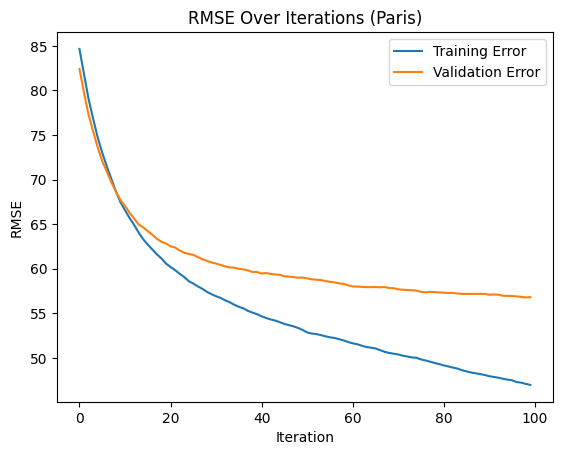

In [27]:
iterations = range(len(catboost_regressor.get_evals_result()['learn']['RMSE']))

plt.plot(iterations, catboost_regressor.get_evals_result()['learn']['RMSE'], label='Training Error')
plt.plot(iterations, catboost_regressor.get_evals_result()['validation']['RMSE'], label='Validation Error')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Over Iterations (Paris)')
plt.legend()
plt.show()

In [28]:
feature_importance = catboost_regressor.get_feature_importance()
print(feature_importance)

[1.69692187e+00 3.62299450e+00 1.14654646e+00 1.54414396e+00
 0.00000000e+00 2.56301070e+01 0.00000000e+00 6.88871967e+00
 5.87797393e+00 1.37580451e+00 1.91640000e+00 3.66581152e+00
 3.77614434e-01 3.70247862e-01 3.80607942e+00 9.66050186e-01
 1.05865419e+00 1.29085249e+00 1.00958701e+00 1.48810916e+00
 1.79692254e+00 1.83002941e+00 1.56092287e+00 2.71513657e+00
 9.12135925e-01 8.73869673e-01 4.45073466e-01 6.19458599e-01
 2.26550653e+00 1.12020268e+00 1.31151415e+00 2.45573519e+00
 2.55584199e+00 4.99603761e-01 5.22979027e+00 8.41799325e+00
 2.57584775e-01 1.27251794e-02 8.29306238e-01 0.00000000e+00
 5.58028734e-01]


In [45]:
print(len(feature_importance))
print(len(X.columns))

print([i for i in X.columns][-5:])

41
46
['prediction', 'price_float', 'overpriced', 'latitude', 'longitude']


Text(0.5, 1.0, 'Feature Importance in the Model (Paris)')

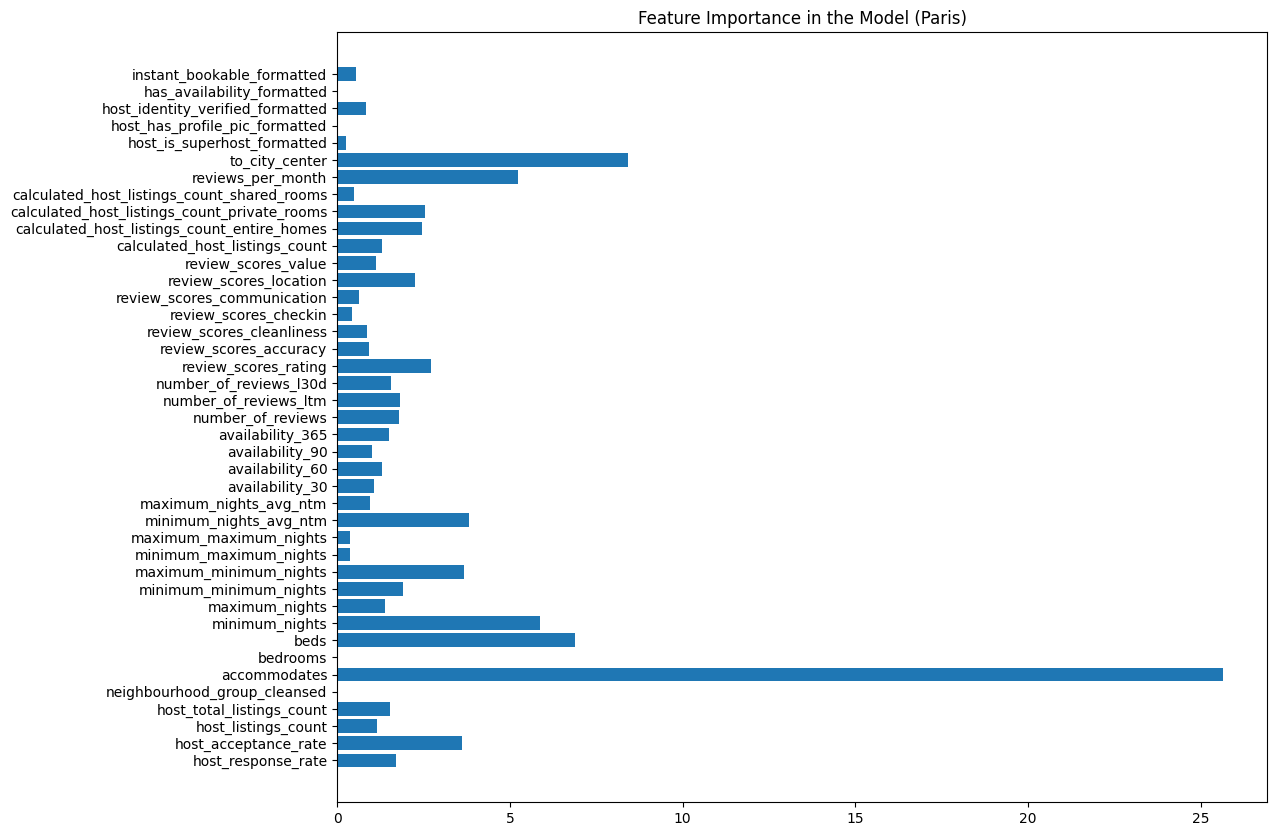

In [46]:
plt.figure(figsize=(12,10))
plt.barh([i for i in X.columns][:41], feature_importance)
plt.title("Feature Importance in the Model (Paris)")

# Save Feature Importance

In [47]:
# create a dict containig feature importance
feature_importance_zipped = zip([i for i in X.columns], feature_importance)
sorted_feature_importance = sorted(feature_importance_zipped, key=lambda x: x[1], reverse=True)

csv_file = '/content/drive/MyDrive/AIT Classes/Data Science/Project/feature_importance/denver_feature_importance.csv'
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Key', 'Value'])
    for i in sorted_feature_importance:
      to_write = [i[0], i[1]]
      writer.writerow(to_write)

Text(0.5, 1.0, 'Performance of prediction set against test set')

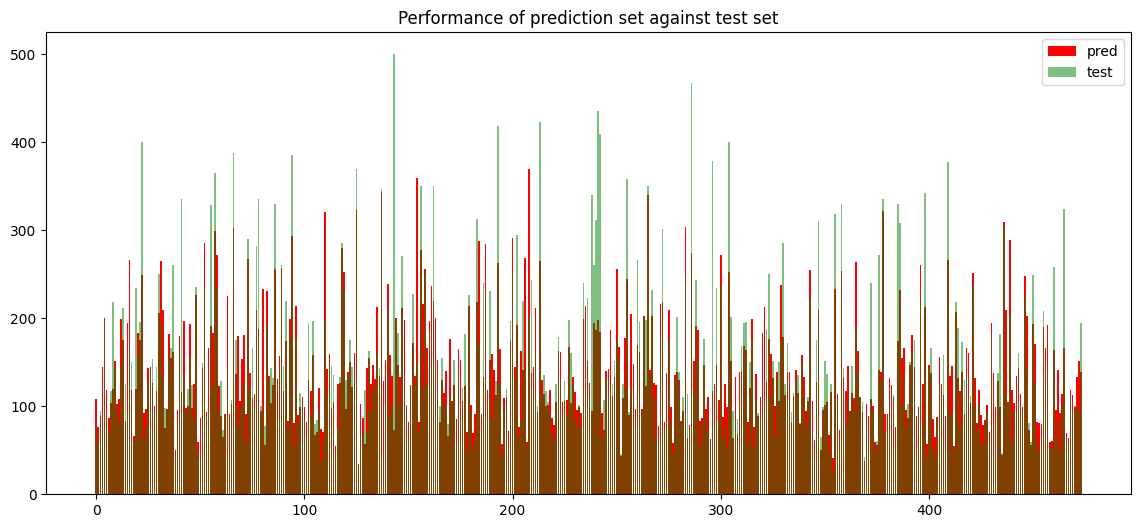

In [48]:
plt.figure(figsize=(14,6))
plt.bar([i for i in range(len(y_pred))], y_pred, color='red', label='pred')
plt.bar([i for i in range(len(y_test))], y_test, color='green', alpha=.5, label='test')
plt.legend()
plt.title('Performance of prediction set against test set')

Text(0.5, 1.0, 'Absolute error for each listing in test set')

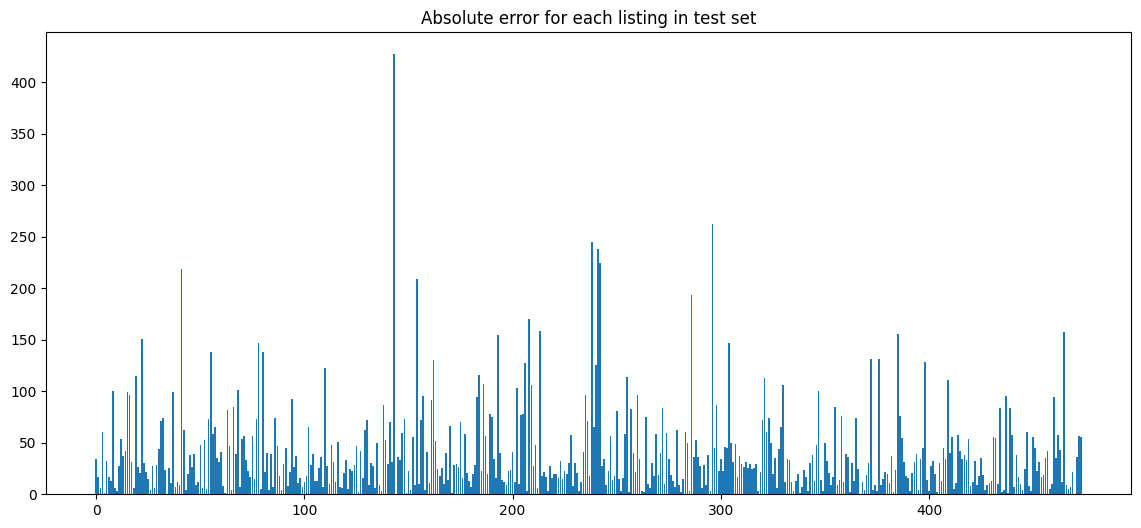

In [49]:
crude_error = []
y_t = y_test.tolist()
y_p = y_pred.tolist()
for i in range(len(y_t)):
  crude_error.append(abs(y_t[i] - y_p[i]))

plt.figure(figsize=(14,6))
plt.bar([i for i in range(len(y_t))], crude_error)
plt.title('Absolute error for each listing in test set')

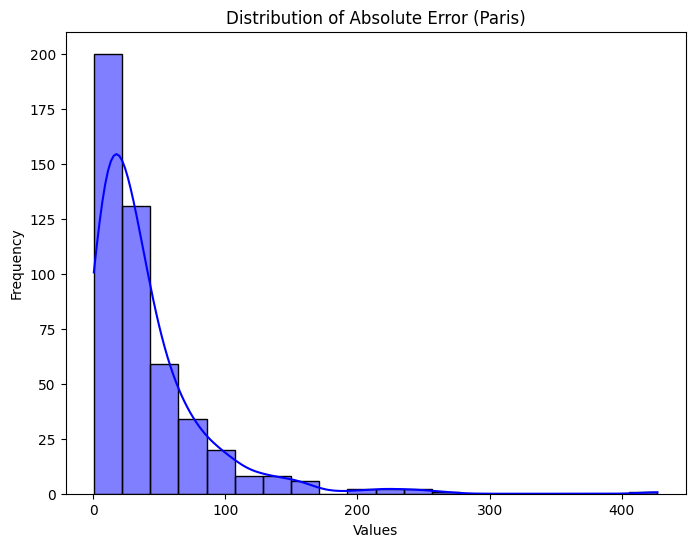

In [50]:
plt.figure(figsize=(8,6))
sns.histplot(crude_error, bins=20, kde=True, color='blue', edgecolor='black')
plt.title('Distribution of Absolute Error (Paris)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()